In [1]:
import math
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
import keras
import tensorflow as tf
import xgboost as xgb

Using TensorFlow backend.


In [2]:
orig_data = pd.read_excel("OppScrData.xlsx")
for col in orig_data.columns:
    new_col = '_'.join(col.split())
    orig_data.rename(columns={col:new_col}, inplace=True)

In [3]:
orig_data.columns[:55]

Index(['Record_ID', 'Visit_ID', 'PT_ID', 'Clinical_F/U_interval_[d_from_CT]',
       'BMI', 'BMI_>30', 'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse',
       'FRS_10-year_risk_(%)', 'FRAX_10y_Fx_Prob_(Orange-w/_DXA)',
       'FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx', 'CLINICAL_OUTCOMES',
       'DEATH_[d_from_CT]', 'CVD_DX', 'CVD_DX_Date_[d_from_CT]',
       'Heart_failure_DX', 'Heart_failure_DX_Date_[d_from_CT]', 'MI_DX',
       'MI_DX_Date_[d_from_CT]', 'Type_2_Diabetes_DX',
       'Type_2_Diabetes_DX_Date_[d_from_CT]', 'Femoral_neck_fracture_DX',
       'Femoral_neck_fracture_DX_Date_[d_from_CT]',
       'Unspec_femoral_fracture_DX',
       'Unspec_femoral_fracture_DX_Date_[d_from_CT]', 'Forearm_fracture_DX',
       'Forearm_fracture_DX_Date_[d_from_CT]', 'Humerus_fracture_DX',
       'Humerus_fracture_DX_Date_[d_from_CT]', 'Pathologic_fracture_DX',
       'Pathologic_fracture_DX_Date_[d_from_CT]', 'Alzheimers_DX',
       'Alzheimers_DX_Date_[d_from_CT]', 'Primary_Cancer_Site

# Death

In [22]:
data = orig_data.copy()

data['BMI_>30'] = np.where(data['BMI_>30']=='Y', 1, 0)
data.rename(columns={'BMI_>30':'BMI_more_than_30'}, inplace=True)
data['Sex'] = np.where(data['Sex']=='Male', 1, 0)
data['Tobacco'] = np.where(data['Tobacco']=='Yes', 1, 0)

data['Alcohol_abuse'] = np.where(data['Alcohol_abuse'].isna(),0,1)

col = 'FRS_10-year_risk_(%)'
data[col] = data[col].astype(str)
data[col] = data[col].str.replace('X','')
data[col] = data[col].str.replace('<1%',str(np.random.uniform(0, 0.01)))
data[col] = data[col].str.replace('>30%',str(np.random.uniform(0.3, 0.99)))
data[col] = pd.to_numeric(data[col], errors='coerce')
data[col] = data[col].astype(float)
med = data[col].median()
data[col] = data[col].fillna(med)
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)

for col in ['FRAX_10y_Fx_Prob_(Orange-w/_DXA)','FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)']:
    data[col] = data[col].astype(str)
    data[col] = data[col].str.replace('_','')
    data[col] = pd.to_numeric(data[col], errors='coerce')
    data[col] = data[col].astype(float)
    med = data[col].median()
    data[col] = data[col].fillna(med)
    upper_limit = data[col].quantile(0.95)
    data[col] = data[col].clip(upper_limit)

data['Met_Sx'] = np.where(data['Met_Sx']=='Y', 1, np.where(data['Met_Sx']=='N', 0, -1))


data['CVD'] = np.where(data['CVD_DX'].isna(),0,1)
data['MI'] = np.where(data['MI_DX'].isna(),0,1)
data['Heart_failure'] = np.where(data['Heart_failure_DX'].isna(),0,1)

data['days'] = data['DEATH_[d_from_CT]']
data['diabetes'] = np.where(data['Type_2_Diabetes_DX'].isna(), 0, 1)

data['L1_HU_BMD'] = data['L1_HU_BMD'].clip(lower=0)
data['TAT/Body_Area'] = data['TAT_Area_(cm2)']/data['Total_Body_Area_EA_(cm2)']
col = 'VAT_Area_(cm2)'
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)
col = 'SAT_Area_(cm2)'
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)
col = 'VAT/SAT_Ratio'
upper_limit = data[col].quantile(0.95)
data[col] = data[col].clip(upper_limit)

data['AoCa_Agatston'] = data['AoCa_Agatston'].clip(upper=data['AoCa_Agatston'].quantile(0.99))
data['AoCa_Agatston'] = data['AoCa_Agatston'].fillna(data['AoCa_Agatston'].median())
data['AoCa_Agatston'] = np.log(data['AoCa_Agatston']+1)

data['Liver_HU_(Median)'] = pd.to_numeric(data['Liver_HU_(Median)'], errors='coerce')
data['Liver_HU_(Median)'] = data['Liver_HU_(Median)'].astype(float)
data['Liver_HU_(Median)'] = data['Liver_HU_(Median)'].fillna(data['Liver_HU_(Median)'].median())
                          
for col in ['BMI','L1_HU_BMD','TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'VAT_Area_(cm2)','SAT_Area_(cm2)',
            'VAT/SAT_Ratio','Muscle_HU','Muscle_Area_(cm2)','L3_SMI_(cm2/m2)','TAT/Body_Area']:
    data[col] = data[col].fillna(data[col].median())

In [23]:
# cols = ['Record_ID', 'Clinical_F/U_interval_[d_from_CT]', 'BMI', 'BMI_>30', 'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse',
#        'FRS_10-year_risk_(%)', 'FRAX_10y_Fx_Prob_(Orange-w/_DXA)',
#        'FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx',
#        'days', 'CVD', 'CVD_DX_Date_[d_from_CT]',
#        'Heart_failure', 'Heart_failure_DX_Date_[d_from_CT]', 'MI',
#        'MI_DX_Date_[d_from_CT]', 'diabetes',
#        'Type_2_Diabetes_DX_Date_[d_from_CT]', 'Femoral_neck_fracture_DX',
#        'Femoral_neck_fracture_DX_Date_[d_from_CT]',
#        'Unspec_femoral_fracture_DX',
#        'Unspec_femoral_fracture_DX_Date_[d_from_CT]', 'Forearm_fracture_DX',
#        'Forearm_fracture_DX_Date_[d_from_CT]', 'Humerus_fracture_DX',
#        'Humerus_fracture_DX_Date_[d_from_CT]', 'Pathologic_fracture_DX',
#        'Pathologic_fracture_DX_Date_[d_from_CT]', 'Alzheimers_DX',
#        'Alzheimers_DX_Date_[d_from_CT]', 'Primary_Cancer_Site',
#        'Primary_Cancer_Dx_[d_from_CT]', 'Primary_Cancer_Site_2',
#        'Primary_Cancer_Site_2_Dx_[d_from_CT]', 'L1_HU_BMD',
#        'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
#        'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
#        'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']

cols = ['Record_ID', 'Clinical_F/U_interval_[d_from_CT]', 'BMI', 'BMI_>30', 'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse',
       'FRS_10-year_risk_(%)', 'FRAX_10y_Fx_Prob_(Orange-w/_DXA)',
       'FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx',
       'days', 'CVD', 'Heart_failure', 'MI', 'diabetes', 'L1_HU_BMD',
       'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']

data = data[cols].copy()
print(data.isna().sum())

Record_ID                                  0
Clinical_F/U_interval_[d_from_CT]          0
BMI                                        0
BMI_>30                                    0
Sex                                        0
Age_at_CT                                  0
Tobacco                                    0
Alcohol_abuse                              0
FRS_10-year_risk_(%)                       0
FRAX_10y_Fx_Prob_(Orange-w/_DXA)           0
FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)       0
Met_Sx                                     0
days                                    8674
CVD                                        0
Heart_failure                              0
MI                                         0
diabetes                                   0
L1_HU_BMD                                  0
TAT_Area_(cm2)                             0
Total_Body_Area_EA_(cm2)                   0
TAT/Body_Area                              0
VAT_Area_(cm2)                             0
SAT_Area_(

In [33]:
train_idx = pd.read_csv('Patients(RECORD_ID)TrainData.csv')['Record_ID']
test_idx = pd.read_csv('Patients(RECORD_ID)_TestData.csv')['Record_ID']
train = data[data['Record_ID'].isin(train_idx)]
test = data[data['Record_ID'].isin(test_idx)]
print(train.shape)
print(test.shape)

(7363, 29)
(1860, 29)


In [47]:
# Train on Non-Null values
train = train[~train['days'].isna()]
val = test[~test['days'].isna()]

In [58]:
feats = ['BMI', 'BMI_more_than_30',
       'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse', 'FRS_10-year_risk_(%)',
       'FRAX_10y_Fx_Prob_(Orange-w/_DXA)','FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx', 'CVD',
       'Heart_failure', 'MI', 'diabetes', 'L1_HU_BMD', 'TAT_Area_(cm2)',
       'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']

label = 'days'
X_train = train[feats].values
Y_train = train[label].values
X_val = val[feats].values
Y_val = val[label].values

In [59]:
eval_set = [(X_train, Y_train), (X_val, Y_val)]
model = xgb.XGBRegressor(n_estimators=500, max_depth=7, eta=0.01, subsample=1, colsample_bytree=1)
model.fit(X_train, Y_train, eval_metric='rmse', eval_set=eval_set)

[0]	validation_0-rmse:2600.26798	validation_1-rmse:2599.26122
[1]	validation_0-rmse:2579.59084	validation_1-rmse:2580.33469
[2]	validation_0-rmse:2559.15584	validation_1-rmse:2561.49219
[3]	validation_0-rmse:2538.96092	validation_1-rmse:2542.90118
[4]	validation_0-rmse:2518.46565	validation_1-rmse:2524.14530
[5]	validation_0-rmse:2498.10937	validation_1-rmse:2505.85409
[6]	validation_0-rmse:2478.58201	validation_1-rmse:2487.95547
[7]	validation_0-rmse:2458.67359	validation_1-rmse:2470.16090
[8]	validation_0-rmse:2439.58537	validation_1-rmse:2452.71995
[9]	validation_0-rmse:2420.20109	validation_1-rmse:2435.16086
[10]	validation_0-rmse:2400.93252	validation_1-rmse:2418.00905
[11]	validation_0-rmse:2381.73632	validation_1-rmse:2400.88648
[12]	validation_0-rmse:2363.48082	validation_1-rmse:2384.39450
[13]	validation_0-rmse:2344.93070	validation_1-rmse:2367.82138
[14]	validation_0-rmse:2326.47546	validation_1-rmse:2351.64680
[15]	validation_0-rmse:2308.82579	validation_1-rmse:2335.82622
[1

/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[55]	validation_0-rmse:1709.14613	validation_1-rmse:1853.75484
[56]	validation_0-rmse:1696.69640	validation_1-rmse:1845.16054
[57]	validation_0-rmse:1684.66363	validation_1-rmse:1836.61450
[58]	validation_0-rmse:1672.72098	validation_1-rmse:1827.82604
[59]	validation_0-rmse:1660.63680	validation_1-rmse:1819.76470
[60]	validation_0-rmse:1648.93695	validation_1-rmse:1811.53772
[61]	validation_0-rmse:1637.04008	validation_1-rmse:1803.89789
[62]	validation_0-rmse:1625.63123	validation_1-rmse:1795.97530
[63]	validation_0-rmse:1613.97404	validation_1-rmse:1788.57418
[64]	validation_0-rmse:1602.80379	validation_1-rmse:1780.86146
[65]	validation_0-rmse:1591.42427	validation_1-rmse:1773.07814
[66]	validation_0-rmse:1580.49051	validation_1-rmse:1765.66279
[67]	validation_0-rmse:1570.12572	validation_1-rmse:1758.40292
[68]	validation_0-rmse:1558.79164	validation_1-rmse:1750.91181
[69]	validation_0-rmse:1548.01916	validation_1-rmse:1743.88344
[70]	validation_0-rmse:1536.86212	validation_1-rmse:173

[185]	validation_0-rmse:816.65163	validation_1-rmse:1364.29049
[186]	validation_0-rmse:813.77535	validation_1-rmse:1363.10590
[187]	validation_0-rmse:810.05064	validation_1-rmse:1361.91325
[188]	validation_0-rmse:807.19244	validation_1-rmse:1360.90453
[189]	validation_0-rmse:803.68840	validation_1-rmse:1359.75065
[190]	validation_0-rmse:800.16281	validation_1-rmse:1358.62544
[191]	validation_0-rmse:796.68021	validation_1-rmse:1357.53948
[192]	validation_0-rmse:793.24823	validation_1-rmse:1356.46855
[193]	validation_0-rmse:789.71209	validation_1-rmse:1355.46165
[194]	validation_0-rmse:787.10479	validation_1-rmse:1354.58598
[195]	validation_0-rmse:784.53728	validation_1-rmse:1353.64434
[196]	validation_0-rmse:781.89840	validation_1-rmse:1352.77715
[197]	validation_0-rmse:779.39588	validation_1-rmse:1351.95276
[198]	validation_0-rmse:776.00747	validation_1-rmse:1351.06854
[199]	validation_0-rmse:773.56800	validation_1-rmse:1350.19275
[200]	validation_0-rmse:771.04007	validation_1-rmse:134

[316]	validation_0-rmse:554.04627	validation_1-rmse:1319.17740
[317]	validation_0-rmse:552.33112	validation_1-rmse:1319.18583
[318]	validation_0-rmse:551.33881	validation_1-rmse:1318.84514
[319]	validation_0-rmse:550.49217	validation_1-rmse:1319.10802
[320]	validation_0-rmse:548.29400	validation_1-rmse:1319.19867
[321]	validation_0-rmse:546.78017	validation_1-rmse:1318.90052
[322]	validation_0-rmse:545.60862	validation_1-rmse:1318.94563
[323]	validation_0-rmse:544.79113	validation_1-rmse:1319.21238
[324]	validation_0-rmse:543.66434	validation_1-rmse:1319.15315
[325]	validation_0-rmse:542.86950	validation_1-rmse:1319.43045
[326]	validation_0-rmse:541.23551	validation_1-rmse:1319.53451
[327]	validation_0-rmse:539.95301	validation_1-rmse:1319.67137
[328]	validation_0-rmse:537.83056	validation_1-rmse:1319.76649
[329]	validation_0-rmse:536.78689	validation_1-rmse:1320.12269
[330]	validation_0-rmse:535.18263	validation_1-rmse:1320.21396
[331]	validation_0-rmse:534.01158	validation_1-rmse:132

[447]	validation_0-rmse:403.36757	validation_1-rmse:1328.81526
[448]	validation_0-rmse:401.98843	validation_1-rmse:1328.87267
[449]	validation_0-rmse:400.92506	validation_1-rmse:1328.78070
[450]	validation_0-rmse:399.54504	validation_1-rmse:1328.89584
[451]	validation_0-rmse:398.90519	validation_1-rmse:1329.10245
[452]	validation_0-rmse:397.85870	validation_1-rmse:1329.05262
[453]	validation_0-rmse:397.27491	validation_1-rmse:1329.44825
[454]	validation_0-rmse:396.66947	validation_1-rmse:1329.58589
[455]	validation_0-rmse:396.20957	validation_1-rmse:1329.69216
[456]	validation_0-rmse:395.60608	validation_1-rmse:1329.83846
[457]	validation_0-rmse:394.24048	validation_1-rmse:1329.95738
[458]	validation_0-rmse:393.61000	validation_1-rmse:1330.08572
[459]	validation_0-rmse:392.25758	validation_1-rmse:1330.18259
[460]	validation_0-rmse:391.43304	validation_1-rmse:1330.24824
[461]	validation_0-rmse:390.77985	validation_1-rmse:1330.39771
[462]	validation_0-rmse:389.43621	validation_1-rmse:133

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.01,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.00999999978, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

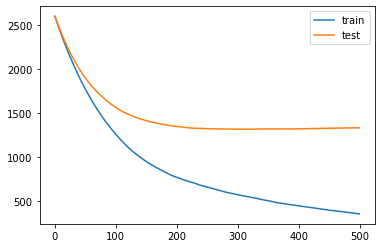

In [60]:
results = model.evals_result()
plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='test')
plt.legend()
plt.show()

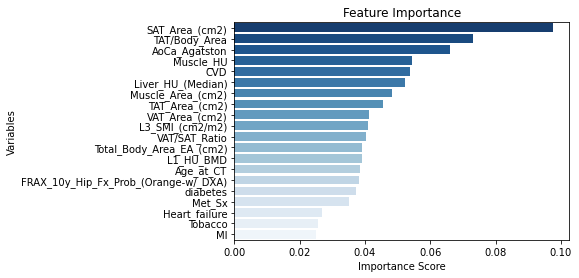

In [61]:
variables_df = pd.DataFrame(feats, columns=['Variables'])
importance_score_df = pd.DataFrame(model.feature_importances_, columns=['Importance Score'])
feature_imp = pd.concat([variables_df, importance_score_df], axis=1)
feature_imp = feature_imp.sort_values(by='Importance Score', ascending=False)
feature_imp = feature_imp.reset_index()
x = 'Importance Score'
y = 'Variables'
sns.barplot(x=x, y=y, data=feature_imp[:20], orient="h", palette="Blues_r")
plt.title('Feature Importance')
plt.show()

1333.7941035392746 2251.4153846153845


<AxesSubplot:xlabel='Y_test', ylabel='preds'>

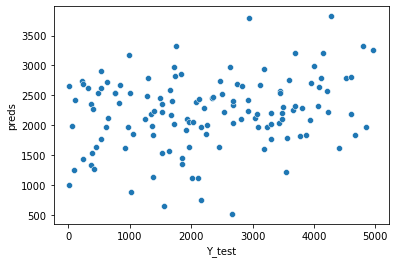

In [62]:
preds = model.predict(X_val)
rmse = math.sqrt(mean_squared_error(Y_val, preds))
print(rmse, Y _val.mean())

tmp = {'Y_test':Y_val,'preds':preds} 
tmp_df = pd.DataFrame(tmp)
tmp_df.sort_values(by='Y_test', inplace=True)
sns.scatterplot(data=tmp_df, x='Y_test', y='preds')

In [71]:
# Prediting on Null values

test_null = test[test['days'].isna()]
X_test_null = test_null[feats].values
preds_test_null = model.predict(X_test_null)

tmp_df = pd.DataFrame(preds)
print(tmp_df.describe())
tmp_df = pd.DataFrame(preds_test_null)
print(tmp_df.describe())

                 0
count   130.000000
mean   2213.480469
std     600.239197
min     524.033142
25%    1877.716522
50%    2232.904419
75%    2621.592957
max    3819.504150
                 0
count  1730.000000
mean   2317.238770
std     507.749725
min     645.558777
25%    1995.093323
50%    2335.141113
75%    2670.464355
max    4027.236084


/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


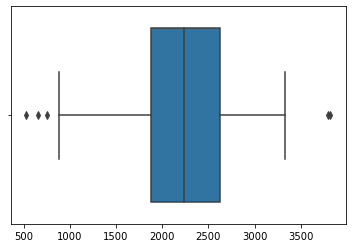

/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

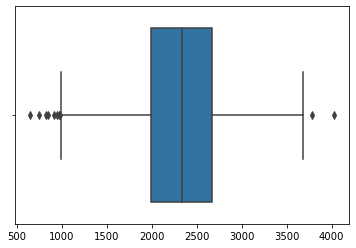

In [68]:
sns.boxplot(preds)
plt.show()
sns.boxplot(preds_test_null)


# Diabetes

In [76]:
data = orig_data.copy()

data['BMI_>30'] = np.where(data['BMI_>30']=='Y', 1, 0)
data.rename(columns={'BMI_>30':'BMI_more_than_30'}, inplace=True)
data['Sex'] = np.where(data['Sex']=='Male', 1, 0)
data['Tobacco'] = np.where(data['Tobacco']=='Yes', 1, 0)

data['Alcohol_abuse'] = np.where(data['Alcohol_abuse'].isna(),0,1)

col = 'FRS_10-year_risk_(%)'
data[col] = data[col].astype(str)
data[col] = data[col].str.replace('X','')
data[col] = data[col].str.replace('<1%',str(np.random.uniform(0, 0.01)))
data[col] = data[col].str.replace('>30%',str(np.random.uniform(0.3, 0.99)))
data[col] = pd.to_numeric(data[col], errors='coerce')
data[col] = data[col].astype(float)
med = data[col].median()
data[col] = data[col].fillna(med)
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)

for col in ['FRAX_10y_Fx_Prob_(Orange-w/_DXA)','FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)']:
    data[col] = data[col].astype(str)
    data[col] = data[col].str.replace('_','')
    data[col] = pd.to_numeric(data[col], errors='coerce')
    data[col] = data[col].astype(float)
    med = data[col].median()
    data[col] = data[col].fillna(med)
    upper_limit = data[col].quantile(0.95)
    data[col] = data[col].clip(upper_limit)

data['Met_Sx'] = np.where(data['Met_Sx']=='Y', 1, np.where(data['Met_Sx']=='N', 0, -1))


data['CVD'] = np.where(data['CVD_DX'].isna(),0,1)
data['MI'] = np.where(data['MI_DX'].isna(),0,1)
data['Heart_failure'] = np.where(data['Heart_failure_DX'].isna(),0,1)

data['days'] = data['Type_2_Diabetes_DX_Date_[d_from_CT]']
data['diabetes'] = np.where(data['Type_2_Diabetes_DX'].isna(), 0, 1)

data['L1_HU_BMD'] = data['L1_HU_BMD'].clip(lower=0)
data['TAT/Body_Area'] = data['TAT_Area_(cm2)']/data['Total_Body_Area_EA_(cm2)']
col = 'VAT_Area_(cm2)'
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)
col = 'SAT_Area_(cm2)'
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)
col = 'VAT/SAT_Ratio'
upper_limit = data[col].quantile(0.95)
data[col] = data[col].clip(upper_limit)

data['AoCa_Agatston'] = data['AoCa_Agatston'].clip(upper=data['AoCa_Agatston'].quantile(0.99))
data['AoCa_Agatston'] = data['AoCa_Agatston'].fillna(data['AoCa_Agatston'].median())
data['AoCa_Agatston'] = np.log(data['AoCa_Agatston']+1)

data['Liver_HU_(Median)'] = pd.to_numeric(data['Liver_HU_(Median)'], errors='coerce')
data['Liver_HU_(Median)'] = data['Liver_HU_(Median)'].astype(float)
data['Liver_HU_(Median)'] = data['Liver_HU_(Median)'].fillna(data['Liver_HU_(Median)'].median())
                          
for col in ['BMI','L1_HU_BMD','TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'VAT_Area_(cm2)','SAT_Area_(cm2)',
            'VAT/SAT_Ratio','Muscle_HU','Muscle_Area_(cm2)','L3_SMI_(cm2/m2)','TAT/Body_Area']:
    data[col] = data[col].fillna(data[col].median())

In [77]:
# cols = ['Record_ID', 'Clinical_F/U_interval_[d_from_CT]', 'BMI', 'BMI_>30', 'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse',
#        'FRS_10-year_risk_(%)', 'FRAX_10y_Fx_Prob_(Orange-w/_DXA)',
#        'FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx',
#        'days', 'CVD', 'CVD_DX_Date_[d_from_CT]',
#        'Heart_failure', 'Heart_failure_DX_Date_[d_from_CT]', 'MI',
#        'MI_DX_Date_[d_from_CT]', 'diabetes',
#        'Type_2_Diabetes_DX_Date_[d_from_CT]', 'Femoral_neck_fracture_DX',
#        'Femoral_neck_fracture_DX_Date_[d_from_CT]',
#        'Unspec_femoral_fracture_DX',
#        'Unspec_femoral_fracture_DX_Date_[d_from_CT]', 'Forearm_fracture_DX',
#        'Forearm_fracture_DX_Date_[d_from_CT]', 'Humerus_fracture_DX',
#        'Humerus_fracture_DX_Date_[d_from_CT]', 'Pathologic_fracture_DX',
#        'Pathologic_fracture_DX_Date_[d_from_CT]', 'Alzheimers_DX',
#        'Alzheimers_DX_Date_[d_from_CT]', 'Primary_Cancer_Site',
#        'Primary_Cancer_Dx_[d_from_CT]', 'Primary_Cancer_Site_2',
#        'Primary_Cancer_Site_2_Dx_[d_from_CT]', 'L1_HU_BMD',
#        'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
#        'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
#        'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']

cols = ['Record_ID', 'BMI', 'BMI_more_than_30', 'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse',
       'FRS_10-year_risk_(%)', 'FRAX_10y_Fx_Prob_(Orange-w/_DXA)',
       'FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx',
       'days', 'CVD', 'Heart_failure', 'MI', 'L1_HU_BMD',
       'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']

data = data[cols].copy()
print(data.isna().sum())

Record_ID                                  0
BMI                                        0
BMI_more_than_30                           0
Sex                                        0
Age_at_CT                                  0
Tobacco                                    0
Alcohol_abuse                              0
FRS_10-year_risk_(%)                       0
FRAX_10y_Fx_Prob_(Orange-w/_DXA)           0
FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)       0
Met_Sx                                     0
days                                    6687
CVD                                        0
Heart_failure                              0
MI                                         0
L1_HU_BMD                                  0
TAT_Area_(cm2)                             0
Total_Body_Area_EA_(cm2)                   0
TAT/Body_Area                              0
VAT_Area_(cm2)                             0
SAT_Area_(cm2)                             0
VAT/SAT_Ratio                              0
Muscle_HU 

In [78]:
train_idx = pd.read_csv('Patients(RECORD_ID)TrainData.csv')['Record_ID']
test_idx = pd.read_csv('Patients(RECORD_ID)_TestData.csv')['Record_ID']
train = data[data['Record_ID'].isin(train_idx)]
test = data[data['Record_ID'].isin(test_idx)]
print(train.shape)
print(test.shape)

(7363, 27)
(1860, 27)


In [79]:
# Train on Non-Null values
train = train[~train['days'].isna()]
val = test[~test['days'].isna()]
print(train.shape)
print(val.shape)

(2035, 27)
(501, 27)


In [80]:
feats = ['BMI', 'BMI_more_than_30', 'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse',
       'FRS_10-year_risk_(%)', 'FRAX_10y_Fx_Prob_(Orange-w/_DXA)',
       'FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx',
        'CVD', 'Heart_failure', 'MI', 'L1_HU_BMD',
       'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']

label = 'days'
X_train = train[feats].values
Y_train = train[label].values
X_val = val[feats].values
Y_val = val[label].values

In [87]:
eval_set = [(X_train, Y_train), (X_val, Y_val)]
model = xgb.XGBRegressor(n_estimators=250, max_depth=7, eta=0.01, subsample=1, colsample_bytree=1)
model.fit(X_train, Y_train, eval_metric='rmse', eval_set=eval_set)

[0]	validation_0-rmse:2191.64526	validation_1-rmse:2186.50286
[1]	validation_0-rmse:2179.71469	validation_1-rmse:2177.62610
[2]	validation_0-rmse:2168.00793	validation_1-rmse:2168.86228
[3]	validation_0-rmse:2156.39908	validation_1-rmse:2160.18926
[4]	validation_0-rmse:2145.00836	validation_1-rmse:2151.78593
[5]	validation_0-rmse:2133.61659	validation_1-rmse:2143.53084
[6]	validation_0-rmse:2122.55788	validation_1-rmse:2135.16000
[7]	validation_0-rmse:2111.59794	validation_1-rmse:2127.21920
[8]	validation_0-rmse:2100.61857	validation_1-rmse:2119.38991
[9]	validation_0-rmse:2089.85795	validation_1-rmse:2111.59032
[10]	validation_0-rmse:2079.37401	validation_1-rmse:2103.88457
[11]	validation_0-rmse:2068.82663	validation_1-rmse:2096.47772
[12]	validation_0-rmse:2058.50247	validation_1-rmse:2089.29986
[13]	validation_0-rmse:2048.42392	validation_1-rmse:2082.00588
[14]	validation_0-rmse:2038.43607	validation_1-rmse:2074.98062
[15]	validation_0-rmse:2028.50595	validation_1-rmse:2067.97568
[1

[130]	validation_0-rmse:1400.73441	validation_1-rmse:1747.48148
[131]	validation_0-rmse:1398.05464	validation_1-rmse:1746.97843
[132]	validation_0-rmse:1394.66015	validation_1-rmse:1746.46177
[133]	validation_0-rmse:1392.13359	validation_1-rmse:1745.77095
[134]	validation_0-rmse:1389.13120	validation_1-rmse:1745.43569
[135]	validation_0-rmse:1386.68637	validation_1-rmse:1745.01292
[136]	validation_0-rmse:1383.28302	validation_1-rmse:1744.66268
[137]	validation_0-rmse:1380.07503	validation_1-rmse:1744.30397
[138]	validation_0-rmse:1377.73018	validation_1-rmse:1743.62360
[139]	validation_0-rmse:1374.93683	validation_1-rmse:1743.34696
[140]	validation_0-rmse:1372.45941	validation_1-rmse:1742.59305
[141]	validation_0-rmse:1369.91708	validation_1-rmse:1742.13771
[142]	validation_0-rmse:1367.51341	validation_1-rmse:1741.56588
[143]	validation_0-rmse:1365.35616	validation_1-rmse:1741.11185
[144]	validation_0-rmse:1362.69305	validation_1-rmse:1740.67055
[145]	validation_0-rmse:1360.44530	valid

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.01,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.00999999978, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=250, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

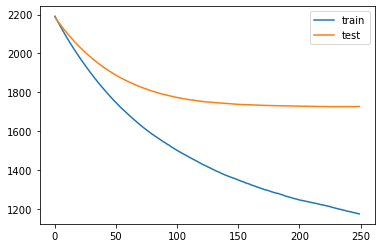

In [88]:
results = model.evals_result()
plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='test')
plt.legend()
plt.show()

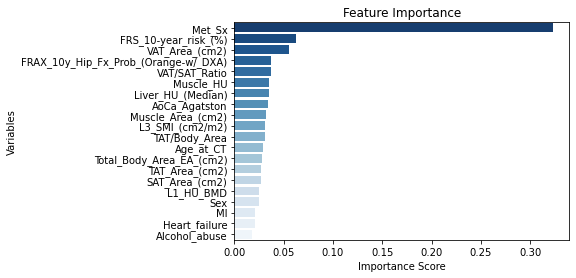

In [89]:
variables_df = pd.DataFrame(feats, columns=['Variables'])
importance_score_df = pd.DataFrame(model.feature_importances_, columns=['Importance Score'])
feature_imp = pd.concat([variables_df, importance_score_df], axis=1)
feature_imp = feature_imp.sort_values(by='Importance Score', ascending=False)
feature_imp = feature_imp.reset_index()
x = 'Importance Score'
y = 'Variables'
sns.barplot(x=x, y=y, data=feature_imp[:20], orient="h", palette="Blues_r")
plt.title('Feature Importance')
plt.show()

1726.8114293098106 1127.566866267465


<AxesSubplot:xlabel='Y_test', ylabel='preds'>

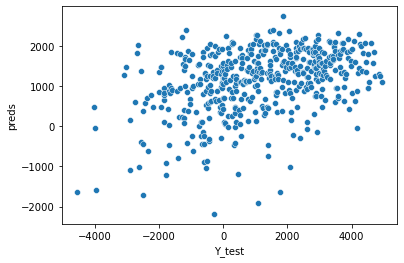

In [92]:
preds = model.predict(X_val)
rmse = math.sqrt(mean_squared_error(Y_val, preds))
print(rmse, Y_val.mean())

tmp = {'Y_test':Y_val,'preds':preds} 
tmp_df = pd.DataFrame(tmp)
tmp_df.sort_values(by='Y_test', inplace=True)
sns.scatterplot(data=tmp_df, x='Y_test', y='preds')

In [93]:
# Prediting on Null values

test_null = test[test['days'].isna()]
X_test_null = test_null[feats].values
preds_test_null = model.predict(X_test_null)

tmp_df = pd.DataFrame(preds)
print(tmp_df.describe())
tmp_df = pd.DataFrame(preds_test_null)
print(tmp_df.describe())

                 0
count   501.000000
mean   1126.426758
std     794.355286
min   -2182.045654
25%     708.194946
50%    1270.946411
75%    1714.232422
max    2734.760742
                 0
count  1359.000000
mean   1504.081055
std     519.825073
min   -1309.343994
25%    1236.346191
50%    1588.261475
75%    1853.362793
max    2989.632080


/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


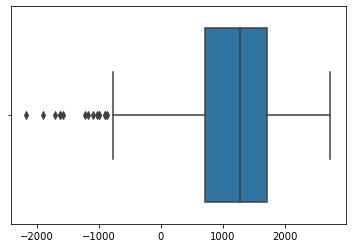

/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

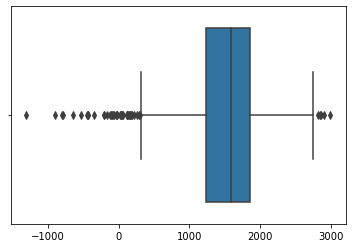

In [94]:
sns.boxplot(preds)
plt.show()
sns.boxplot(preds_test_null)

In [96]:
preds_test_null.shape

(1359,)

In [104]:
extra = preds_test_null.shape[0] - preds.shape[0]
null_array = np.empty(extra)
preds_concat = np.concatenate((preds, null_array), axis=0)

tmp_df = pd.DataFrame({'preds_test_null':preds_test_null})
tmp_df['preds'] = preds_concat

# Heart Attack